## WiDS Datathon 2019

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore') 
from fastai.vision import *
from fastai import *

In [2]:
image_dir = '/home/hanzhang/HZ_project/train_images/'
df = pd.read_csv('df_new.csv') 

In [3]:
test = glob.glob("/home/hanzhang/HZ_project/leaderboard_test_data/*.jpg")
#holdout = glob.glob("/mnt/disks/disk3/widsdatathon2019/leaderboard_holdout_data/*.jpg")
X_test = pd.DataFrame(test,columns=['image_id'])['image_id'].apply(lambda x: x.split("/")[-1]) 

In [4]:
df.head() 

,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [5]:
df.info() # no missing value 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20896 entries, 0 to 20895
Data columns (total 3 columns):
image_id       20896 non-null object
has_oilpalm    20896 non-null int64
score          20896 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 489.8+ KB


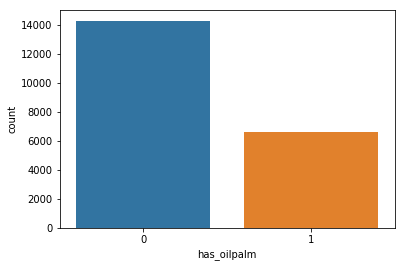

In [6]:
# countplot 
sns.countplot(df['has_oilpalm'])

In [7]:
print(df[df['has_oilpalm']==1]['score'].mean())
print(df[df['has_oilpalm']==0]['score'].mean())

0.9414717622080674
0.9567108306530554


### Visualization 
1. high confidence labels
2. low confidence labels 

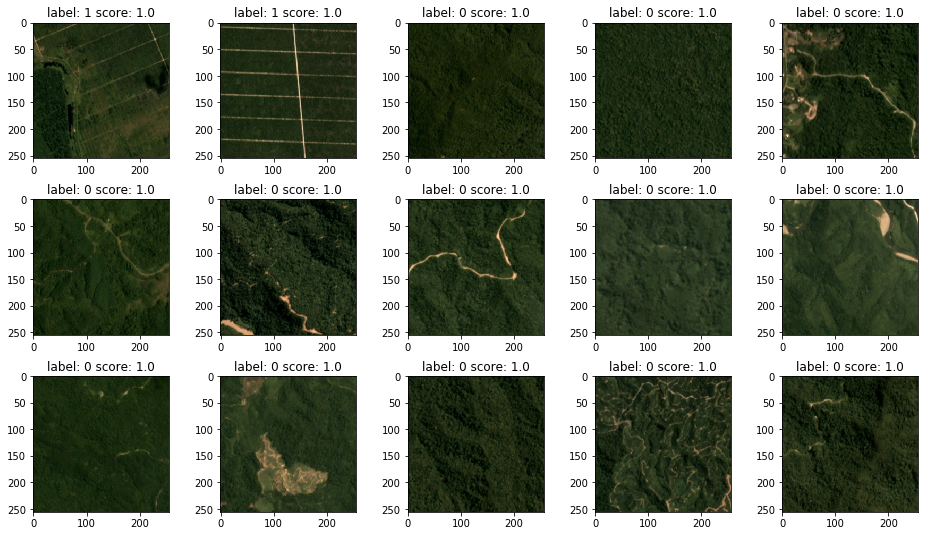

In [9]:
df_hc = df[df['score']==1] 
sample = df_hc.sample(n=15)
f_name = sample['image_id'].values
label = sample['has_oilpalm'].values
score = sample['score'].values

import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(16, 9))
count = 0
for i in f_name:
    im = Image.open(image_dir + i)
    count = count+1
    fig.add_subplot(3, 5, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(im)
    plt.title('label: '+str(label[count-1])+' '+ 'score: '+str(round(score[count-1],3)))

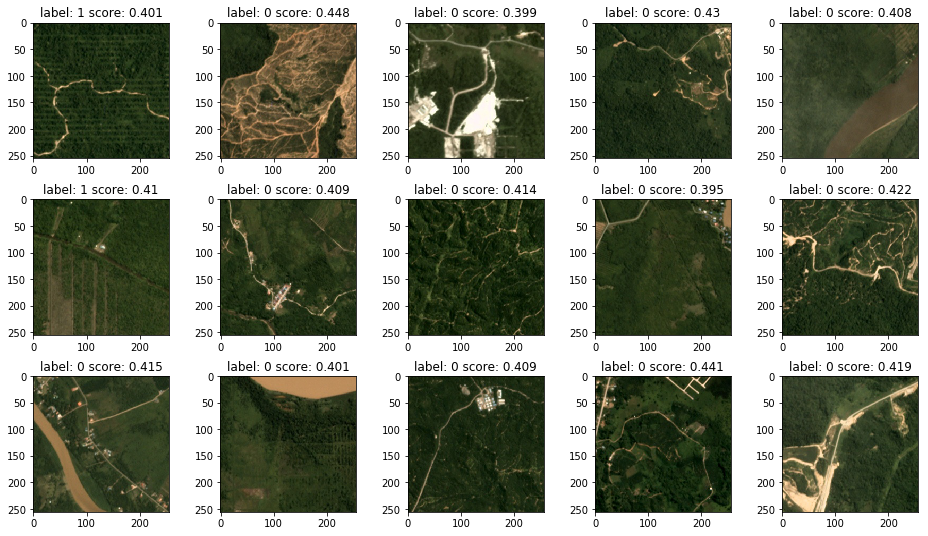

In [10]:
df_lc = df[df['score']<0.5] 

sample = df_lc.sample(n=15)
f_name = sample['image_id'].values
label = sample['has_oilpalm'].values
score = sample['score'].values

import matplotlib.pyplot as plt
from PIL import Image

fig=plt.figure(figsize=(16, 9))
count = 0
for i in f_name:
    im = Image.open(image_dir + i)
    count = count+1
    fig.add_subplot(3, 5, count)
    fig.subplots_adjust(hspace=0.3,wspace=0.3)
    plt.imshow(im)
    plt.title('label: '+str(label[count-1])+' '+ 'score: '+str(round(score[count-1],3)))

### Preprocessing  

In [10]:
df_1 = df[df['has_oilpalm']==0]#.sample(frac=0.8)
df_2 = df[df['has_oilpalm']==1]
dt_m = pd.concat([df_1,df_2]).reset_index(drop=True)
dt_m.groupby('has_oilpalm').count()['image_id'] 

has_oilpalm
0    14302
1     6594
Name: image_id, dtype: int64

In [11]:
#dt_m = df.sample(frac = 0.05)

### resnet50  

In [12]:
path=Path('/home/hanzhang/HZ_project/')
test =  path/'leaderboard_test_data'

In [13]:
test_names = [f for f in test.iterdir()]

In [14]:
data = (ImageItemList.from_df(dt_m, path, folder='train_images')
      .random_split_by_pct(0.05)
      .label_from_df('has_oilpalm')
      .add_test(test_names)
      .transform(get_transforms(),size=256)
      .databunch(bs=64, num_workers=4)
      .normalize(imagenet_stats))

In [16]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


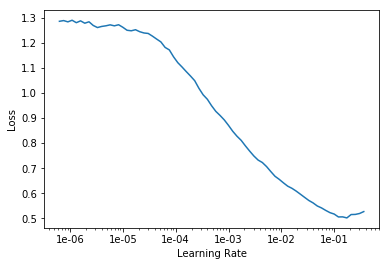

In [183]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.067241,0.073275,0.983716
2,0.055404,0.073013,0.976054
3,0.045453,0.030437,0.986590
4,0.020781,0.027019,0.992337
5,0.012491,0.017892,0.995211


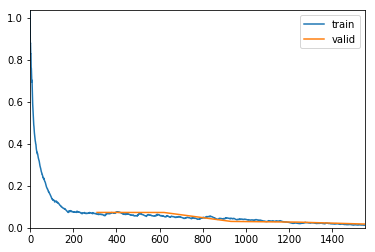

In [17]:
learn.unfreeze()
learn.fit_one_cycle(5, slice(1e-4, 1e-3))

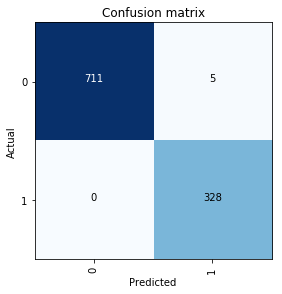

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix() 

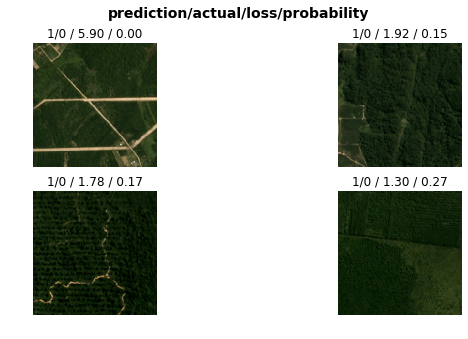

In [24]:
interp.plot_top_losses(4, figsize=(10,5)) 

In [ ]:
#learn.save('256_resnet_all')

In [18]:
p,t = learn.get_preds()

In [19]:
from sklearn.metrics import roc_auc_score,roc_curve,recall_score,classification_report,confusion_matrix
print(roc_auc_score(t,p[:,1]))
classes = np.argmax(p, axis=1)
print(confusion_matrix(t,classes))

0.9998722578007903
[[711   5]
 [  0 328]]


### LB 
1. frac 0.1/all the data/resnet34/256/ val auc score 0.99632 
2. frac 0.1/all the data/resnet50/256/ val auc score 0.9996  echo 2 ()
2. frac 0.1/all the data/resnet50/256/ val auc score 0.99998  echo 3 (143 0 1 46)
2. frac 0.1/all the data/resnet50/128/ val auc score 0.99935308578  echo 2 (131 0 3 56) 
frac 0.1/0.8label0 resnet50 128 auc score 1.0 echo3 best one
frac 0.1/all /resnet50/256/ bs 64   val 0.9990 echo3 (69 2 0 28) 

2. frac 0.1/all the data/VGG19// val auc score 0.9996  echo 2 ()

3. all the data/resnet50/256/bs 128 /val auc score 0.99982063 (1412 11 3 475) echo 3 submission res 0.995 
4. all the data/resnet50/128/bs 64 /val auc score  echo 3  [[723   2] [  5 267]]
5. all the data/resnet50/256/bs 64/val auc score  [[690 6][  2 299]] echo 3 

6 times augmentation 
0.9997247122382616
[[717   5]
 [  3 319]]



In [20]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [21]:
sub = pd.DataFrame(np.stack([X_test, p[:,1]], axis=1), columns=['image_id','has_oilpalm'])

In [22]:
sub.to_csv('submission_256_resnet50_aug6_echo5.csv', index=False)

### Keras 

In [1]:
from skimage.transform import resize

In [7]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from sklearn.model_selection import train_test_split

#Splitting 
y = dt_m['has_oilpalm']
X = dt_m['image_id']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1) 

In [8]:
# Original Dimensions
image_width = 256
image_height = 256
channels = 3

In [71]:
img = load_img(image_dir+df['image_id'][0],target_size=(224, 224))
x = img_to_array(img) 
a = resize(x, (224, 224, 3), mode='constant', preserve_range=True)

In [9]:
from keras.applications.imagenet_utils import preprocess_input

In [13]:
def CreateDataset(X,image_dir,image_width,image_height,channels):
    dataset_X = np.ndarray(shape=(len(X),image_height, image_width, channels),
                     dtype=np.float32)
    i = 0
    for _file in X.values:
        img = load_img(image_dir + _file, target_size=(256,256))  # this is a PIL image
        #img.thumbnail((image_width, image_height))
        # Convert to Numpy Array
        x = img_to_array(img)  
        # Normalize
        # x = (x / 255) #x = resize(x, (128, 128, 3), mode='constant', preserve_range=True)
        dataset_X[i] = preprocess_input(x)/255
        i += 1
    return dataset_X 

In [14]:
dataset_X_train = CreateDataset(X_train,image_dir,256,256,channels) 

In [15]:
dataset_X_val = CreateDataset(X_val,image_dir,256,256,channels)

In [48]:
dataset_X_test = CreateDataset(X_test,'/mnt/disks/disk3/widsdatathon2019/leaderboard_test_data/',\
            image_width,image_height,channels) 

In [16]:
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import adam,SGD


input_shape = (256, 256, 3)

model = Sequential()
model.add(Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0', input_shape = input_shape))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))
model.add(BatchNormalization(axis = 3))

model.add(Flatten())
model.add(Dense(500, activation="relu", name='rl'))
#model.add(Dropout(0.8))
model.add(Dense(1, activation='sigmoid'))

adam = adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv0 (Conv2D)               (None, 250, 250, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 250, 250, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 125, 125, 32)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 123, 123, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 123, 123, 64)      0         
_________________________________________________________________
avg_

In [17]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto')
history = model.fit(dataset_X_train, y_train,\
                    batch_size=32, epochs=20,verbose=1,validation_data=(dataset_X_val, y_val),callbacks=[reduce_lr])
score = model.evaluate(dataset_X_val, y_val, verbose=0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])  

Instructions for updating:
Use tf.cast instead.
Train on 940 samples, validate on 105 samples
Epoch 1/20
940/940 [==============================] - 157s 167ms/step - loss: 3.8882 - acc: 0.7372 - val_loss: 10.7801 - val_acc: 0.3238
Epoch 2/20
940/940 [==============================] - 153s 163ms/step - loss: 3.9856 - acc: 0.7511 - val_loss: 9.5654 - val_acc: 0.4000
Epoch 3/20
940/940 [==============================] - 154s 164ms/step - loss: 4.0080 - acc: 0.7489 - val_loss: 10.7801 - val_acc: 0.3238
Epoch 4/20
940/940 [==============================] - 154s 163ms/step - loss: 4.1431 - acc: 0.7383 - val_loss: 4.7537 - val_acc: 0.7048
Epoch 5/20
940/940 [==============================] - 154s 163ms/step - loss: 3.6426 - acc: 0.7702 - val_loss: 4.9005 - val_acc: 0.6952
Epoch 6/20
940/940 [==============================] - 154s 164ms/step - loss: 3.7496 - acc: 0.7660 - val_loss: 4.4366 - val_acc: 0.7238
Epoch 7/20
940/940 [==============================] - 154s 164ms/step - loss: 3.8164 - a

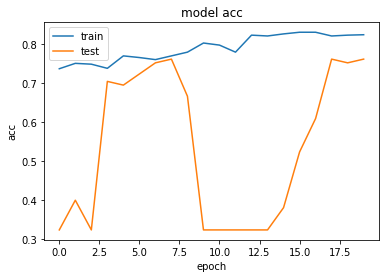

In [19]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
base_model = resnet50.ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(256, 256, 3))

In [4]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)

    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("keras_train", image_size, shuffle=False, 
                                              batch_size=128)
    test_generator = gen.flow_from_directory("test", image_size, shuffle=False, 
                                             batch_size=128, class_mode=None)


    train = model.predict_generator(train_generator, train_generator.samples) # nb_sample does not exist 
    test = model.predict_generator(test_generator, test_generator.samples)
    print(type(test))
    with h5py.File("gap_%s.h5"%MODEL.__name__) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [ ]:
write_gap(ResNet50, (256, 256)) 

In [ ]:
np.array(h['train'])

In [ ]:
X_train = []
X_test = []
with h5py.File("gap_wrapper.h5", 'r') as h:
    print(len(np.array(h['train'])))
    X_train.append(np.array(h['train']))
    X_test.append(np.array(h['test']))
    y_train = np.array(h['label'])

In [ ]:
np.shape(X_test)

In [25]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

In [26]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

#val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [ ]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)